In [62]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [63]:
#!pip install fastai
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
import seaborn as sns
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import * 
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Sequential

In [64]:
class encoder(tf.keras.layers.Layer):

    def __init__(
        self,
        vocab_size, num_layers, units, d_model, num_heads, dropout,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.units = units
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout
        


In [65]:
 def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [66]:
data = pd.read_csv('/content/drive/MyDrive/CARAS/fer2013.csv')

In [67]:
print(data.shape)
print(data.columns)
data.head()

(35887, 3)
Index(['emotion', 'pixels', 'Usage'], dtype='object')


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [69]:
data['pixels_graph'] = data['pixels'].apply (lambda x : x.split(' '))
data['pixels_graph'] = data['pixels_graph'].apply (lambda x : np.reshape(x, (48,48)))

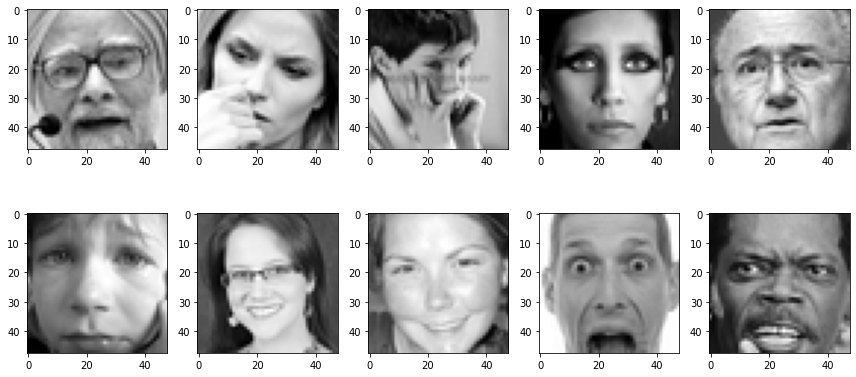

In [70]:
plt.figure(0, figsize=(12,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(data['pixels_graph'][i].astype(int), cmap = 'gray')
plt.tight_layout()
plt.show()

In [71]:
training = data.loc[data["Usage"] == "Training"]
public_test = data.loc[data["Usage"] == "PublicTest"]
private_test = data.loc[data["Usage"] == "PrivateTest"]

print("Training = ", training.shape)
print("Public_test = ", public_test.shape)
print("Private_test = ", private_test.shape)

Training =  (28709, 4)
Public_test =  (3589, 4)
Private_test =  (3589, 4)


In [72]:
train_labels = training["emotion"]
train_labels = to_categorical(train_labels)

val_labels = private_test["emotion"]
val_labels = to_categorical(val_labels)

test_labels = public_test["emotion"]
test_labels = to_categorical(test_labels)

In [73]:
train_images = training["pixels"].str.split(" ").tolist()
train_images = np.uint8(train_images)
train_images = train_images.reshape((train_images.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = private_test["pixels"].str.split(" ").tolist()
val_images = np.uint8(val_images)
val_images = val_images.reshape((val_images.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = public_test["pixels"].str.split(" ").tolist()
test_images = np.uint8(test_images)
test_images = test_images.reshape((test_images.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


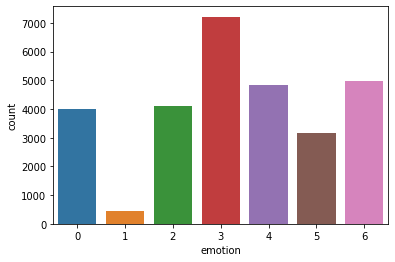

In [74]:
sns.countplot(training["emotion"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


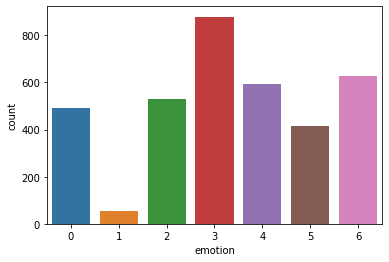

In [75]:
sns.countplot(private_test["emotion"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


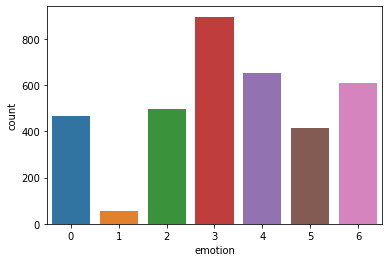

In [76]:
sns.countplot(public_test["emotion"])

In [77]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [78]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,)

In [79]:
datagen.fit(train_images)

In [80]:
model = models.Sequential()
model.add(Conv2D(64, (5, 5), activation='elu', padding = 'same', kernel_initializer = 'he_normal',input_shape=(48, 48, 1)))
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Conv2D(64, (5, 5), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_2'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Conv2D(128, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_4'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Conv2D(256, (3, 3), activation='elu', padding = 'same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization(name='batchnorm_6'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization(name='batchnorm_7'))
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer= optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [82]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', min_delta = 0.00005, patience = 9, verbose = 1, restore_best_weights = True)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 7, min_lr = 1e-7, verbose = 1)

callbacks = [ early_stopping, lr_scheduler]

In [83]:
batch_size = 32

In [84]:
datagen.fit(train_images)

In [85]:
history = model.fit(datagen.flow(train_images , train_labels, batch_size= batch_size),
                    validation_data=(val_images, val_labels),
                    epochs=60,
                    steps_per_epoch = len(train_images)/batch_size,
                    callbacks = callbacks)

Epoch 1/60
897/897 [==============================] - 48s 51ms/step - loss: 2.4283 - accuracy: 0.2007 - val_loss: 1.6504 - val_accuracy: 0.3566
Epoch 2/60
897/897 [==============================] - 45s 50ms/step - loss: 1.7075 - accuracy: 0.3168 - val_loss: 1.5758 - val_accuracy: 0.3873
Epoch 3/60
897/897 [==============================] - 45s 50ms/step - loss: 1.5372 - accuracy: 0.4017 - val_loss: 1.4231 - val_accuracy: 0.4678
Epoch 4/60
897/897 [==============================] - 45s 50ms/step - loss: 1.4271 - accuracy: 0.4505 - val_loss: 1.2947 - val_accuracy: 0.5057
Epoch 5/60
897/897 [==============================] - 45s 50ms/step - loss: 1.3507 - accuracy: 0.4833 - val_loss: 1.2042 - val_accuracy: 0.5433
Epoch 6/60
897/897 [==============================] - 45s 50ms/step - loss: 1.3078 - accuracy: 0.5069 - val_loss: 1.1931 - val_accuracy: 0.5486
Epoch 7/60
897/897 [==============================] - 45s 50ms/step - loss: 1.2583 - accuracy: 0.5240 - val_loss: 1.1115 - val_accuracy:

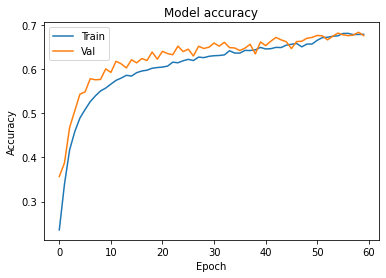

In [86]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.ylim(0, 1)
plt.show()

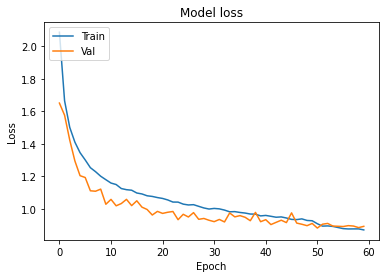

In [87]:
# Plot training and test loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left') 
plt.show()

In [88]:
results = model.evaluate(test_images, test_labels)

113/113 [==============================] - 2s 17ms/step - loss: 0.9420 - accuracy: 0.6687


In [89]:
prediccion = model.predict(test_images)

In [90]:
matrix = metrics.confusion_matrix(test_labels.argmax(axis=1), prediccion.argmax(axis=1))

In [91]:
matrix

array([[301,   7,  27,  15,  44,   8,  65],
       [ 18,  27,   1,   1,   7,   0,   2],
       [ 75,   2, 179,  13, 102,  39,  86],
       [ 15,   1,  14, 780,   7,  17,  61],
       [ 64,   1,  44,  20, 348,   9, 167],
       [ 19,   0,  29,  14,   7, 328,  18],
       [ 39,   0,  21,  41,  65,   4, 437]])